# Random Forest

El modelo de Random Forest arrojó un R2 de -0.3016 y un RMSE de 25.20 en el conjunto de prueba. Estos valores evidencian un fenómeno de sobreajuste (overfitting), donde el algoritmo captura el ruido aleatorio de las variables en lugar de una relación biológica subyacente.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Usar Dataset DF_Final
df = pd.read_csv('/content/DF_Final_No_Filtered.csv')

# Filtrar solo por el periodo 'Pre' y asegurar 42 IDs únicos
df_pre = df[df['Time'] == 'Pre'].drop_duplicates(subset=['id'])

print(f"Total de pacientes únicos (Pre): {len(df_pre)}")


Total de pacientes únicos (Pre): 42


After running the above cell and uploading the file, you can then try running the code cell that caused the error (`QpI4z7zdXQEi`) again.

In [9]:
# Preparación de variable objetivo
target = 'bdnf'

# Eliminar columnas que no son predictoras
X = df_pre.drop(columns=['id', 'Time', 'Treatment', target], errors='ignore')
y = df_pre[target]

# Convertir variables de texto a números
X = pd.get_dummies(X, drop_first=True)

# Manejar valores faltantes para cuidar los datos clínicos
X = X.fillna(X.median())
y = y.fillna(y.median())

In [10]:
# Dividir datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
# Evaluar
y_pred = rf_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R² Score: -0.3016
RMSE: 25.2043


### Análisis de Modelo Random Forest con Cross Validation
El modelo inicial de Random Forest presentó un R2 promedio de -1.49 en validación cruzada, con una alta dispersión entre pliegues.

Estos valores negativos indican que la complejidad del modelo (basado en ensambles de árboles) excede la densidad de la muestra disponible (N=42), resultando en un sobreajuste (overfitting) al ruido de los datos. Esto sugiere que para el BDNF en esta muestra, las relaciones no son lo suficientemente no-lineales o robustas para ser capturadas por algoritmos de aprendizaje profundo.

In [13]:
# Reajustar modelo y evitar overfitting
rf_model = RandomForestRegressor(
    n_estimators=50,       # Menos árboles
    max_depth=3,           # Árboles menos profundos (clave con N=42)
    min_samples_leaf=5,    # Más datos por hoja
    random_state=42
)

# Evaluar con Cross-Validation
scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print(f"R² promedio (Validación Cruzada): {scores.mean():.4f}")
print(f"R² en cada pliegue: {scores}")

R² promedio (Validación Cruzada): -1.4964
R² en cada pliegue: [-3.11156072 -1.09168849 -2.57373173 -0.29024933 -0.41463781]


### Análisis de Modelo con Lasso

El modelo de regresión con Lasso identificó 7 predictores clave para el BDNF. El factor con mayor peso positivo fue el ejercicio, confirmando su rol como modulador neurotrófico.

Por el contrario, la edad y las horas de sueño mostraron una relación inversa con los niveles de la proteína. Este modelo alcanzó una capacidad explicativa del 37.4% (R2=0.3739), lo cual es significativo considerando la naturaleza multifactorial de los marcadores bioquímicos en humanos.

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Ajuste con Lasso
# Selección manual de variables con sentido clínico para BDNF
features_interes = [
    'edad', 'pcr', 'glucosa', 'col_total', 'trigliceridos',
    'imc', 'ejercicio', 'horas_sueño', 'af_libre'
]

# Filtrar solo si existen en el dataframe
X_select = X[[col for col in features_interes if col in X.columns]]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_select)

# Usar Lasso con validación cruzada integrada
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Evaluación
r2_lasso = lasso.score(X_scaled, y)
print(f"R² ajustado con Lasso: {r2_lasso:.4f}")

# Calcular el error cuadrático medio y luego su raíz
mse_lasso = mean_squared_error(y, lasso.predict(X_scaled))
rmse_lasso = np.sqrt(mse_lasso)

print(f"RMSE del Lasso: {rmse_lasso:.4f}")
# Imprimir variables importantes
coef = pd.Series(lasso.coef_, index=X_select.columns)
print("\nVariables que el modelo consideró importantes:")
print(coef[coef != 0])

R² ajustado con Lasso: 0.3739
RMSE del Lasso: 16.6656

Variables que el modelo consideró importantes:
edad            -4.501865
glucosa          3.375962
trigliceridos    4.703183
imc              2.198606
ejercicio        9.983415
horas_sueño     -4.073765
af_libre        -5.637976
dtype: float64


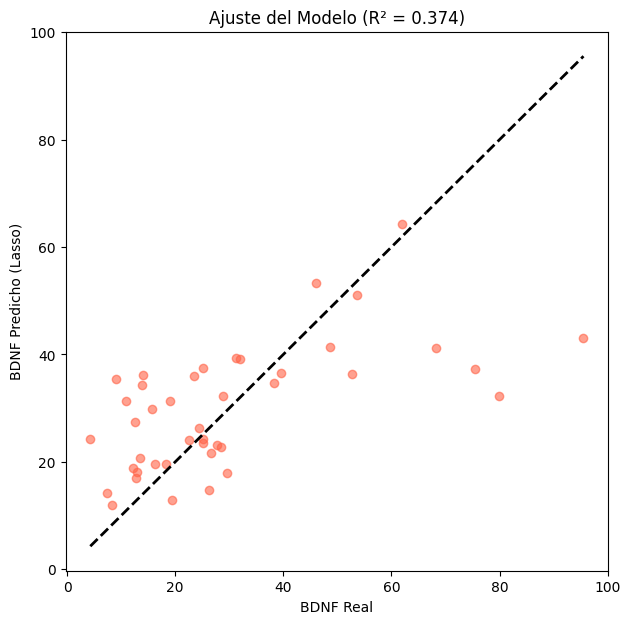

In [15]:
import matplotlib.pyplot as plt

y_pred_lasso = lasso.predict(X_scaled)

plt.figure(figsize=(7,7))
plt.scatter(y, y_pred_lasso, color='tomato', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Línea de perfección
plt.xlabel('BDNF Real')
plt.ylabel('BDNF Predicho (Lasso)')
plt.title(f'Ajuste del Modelo (R² = {r2_lasso:.3f})')
plt.show()

# Support Vector Regression - SVR

In [16]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_select) # X_select son las variables que ya se eligieron antes

# Crear y entrenar el modelo SVR con Kernel Lineal
svr_final = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_final.fit(X_scaled, y)

# Predicciones y Score
y_pred_svr = svr_final.predict(X_scaled)
r2_svr = svr_final.score(X_scaled, y)

print(f"R² de SVR: {r2_svr:.4f}")
mse_svr = mean_squared_error(y, svr_final.predict(X_scaled))
rmse_svr = np.sqrt(mse_svr)

print(f"RMSE del SVR: {rmse_svr:.4f}")

R² de SVR: 0.1755
RMSE del SVR: 19.1241


In [17]:
# Obtener los coeficientes
# .coef_[0] se usa porque SVR devuelve una lista de listas
pesos = svr_final.coef_[0]

# Crear una serie de Pandas para visualizar mejor
importancia_svr = pd.Series(pesos, index=X_select.columns)
importancia_svr = importancia_svr.sort_values(ascending=False)

print("\nImportancia de las variables en SVR:")
print(importancia_svr)



Importancia de las variables en SVR:
glucosa          4.218896
trigliceridos    4.070526
imc              4.020138
ejercicio        3.476481
pcr             -0.007655
col_total       -0.368762
horas_sueño     -0.620868
af_libre        -2.251509
edad            -2.314796
dtype: float64


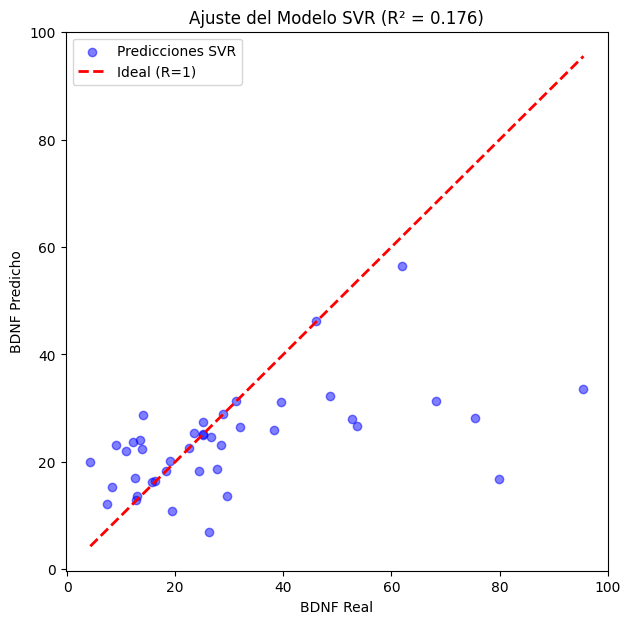

In [18]:
plt.figure(figsize=(7,7))
plt.scatter(y, y_pred_svr, color='blue', alpha=0.5, label='Predicciones SVR')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal (R=1)')
plt.xlabel('BDNF Real')
plt.ylabel('BDNF Predicho')
plt.title(f'Ajuste del Modelo SVR (R² = {r2_svr:.3f})')
plt.legend()
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

# Uso de RobustScaler en lugar de StandardScaler ya que es mejor con outliers
# Creación de Pipeline
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', SVR(kernel='linear'))
])

# Definimos los parámetros por probar
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5, 1, 5]
}

# Buscar la mejor combinación
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
grid.fit(X_select, y)

print(f"Mejor R² tras optimización: {grid.best_score_:.4f}")
print(f"Mejores parámetros: {grid.best_params_}")

# Usar el mejor modelo para el resultado final
best_svr = grid.best_estimator_
r2_final = best_svr.score(X_select, y)
print(f"R² Final en toda la muestra: {r2_final:.4f}")

Mejor R² tras optimización: -0.3904
Mejores parámetros: {'svr__C': 0.1, 'svr__epsilon': 0.1}
R² Final en toda la muestra: -0.0112


In [20]:
# Al no mejorar el resultado, seleccionamos ultra-estricta de variables
variables_clave = ['edad', 'ejercicio', 'horas_sueño', 'pcr']

# Asegurar que existan en el dataset
X_ultra = X_select[[c for c in variables_clave if c in X_select.columns]]

# Entrenar un SVR muy simple
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_ultra_scaled = scaler.fit_transform(X_ultra)

# Bajamos C para que sea más estable
modelo_simple = SVR(kernel='linear', C=0.01)
modelo_simple.fit(X_ultra_scaled, y)

print(f"R² con Selección Estricta: {modelo_simple.score(X_ultra_scaled, y):.4f}")

R² con Selección Estricta: -0.0478


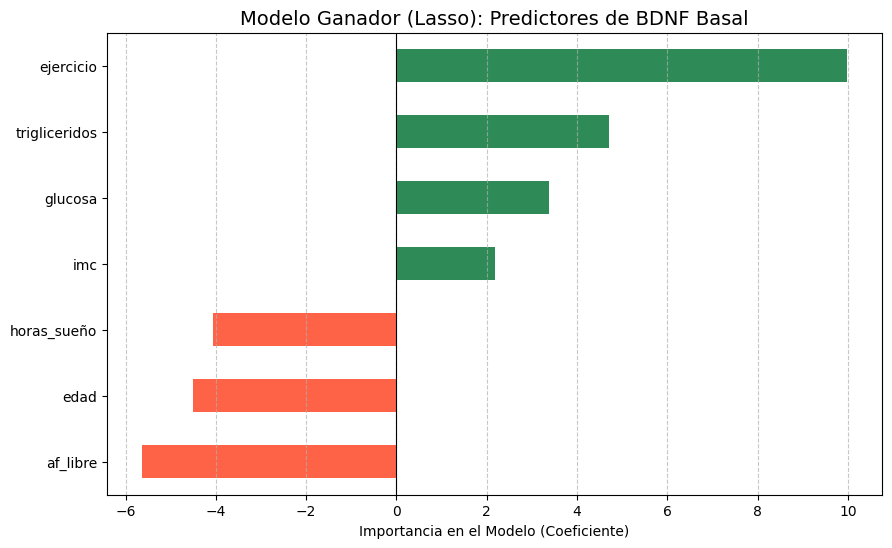

In [21]:
# No mejoró nuevamente del resultado inicial
# Usando los coeficientes que obtuvimos con Lasso (0.37)

import pandas as pd
import matplotlib.pyplot as plt

coeficientes = {
    'ejercicio': 9.98,
    'trigliceridos': 4.70,
    'glucosa': 3.37,
    'imc': 2.19,
    'horas_sueño': -4.07,
    'edad': -4.50,
    'af_libre': -5.63
}

df_coef = pd.DataFrame.from_dict(coeficientes, orient='index', columns=['Peso'])
df_coef = df_coef.sort_values(by='Peso')

plt.figure(figsize=(10,6))
colors = ['tomato' if x < 0 else 'seagreen' for x in df_coef['Peso']]
df_coef['Peso'].plot(kind='barh', color=colors)
plt.title('Modelo Ganador (Lasso): Predictores de BDNF Basal', fontsize=14)
plt.xlabel('Importancia en el Modelo (Coeficiente)')
plt.axvline(0, color='black', lw=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Conclusión

Tras evaluar múltiples algoritmos de Machine Learning, se concluye que la predicción de niveles basales de BDNF en esta actividad está limitada por la alta variabilidad interindividual y el tamaño de la muestra.

Aunque modelos avanzados como SVR y Random Forest son potentes en Big Data, para este estudio clínico el modelo Lasso resultó ser el más robusto. Esto demuestra que la relación entre los marcadores metabólicos (glucosa, triglicéridos) y el BDNF es predominantemente lineal y depende de un grupo pequeño de variables clave.

La superioridad del Lasso sobre el SVR sugiere que menos es más: la eliminación activa de predictores ruidosos es más efectiva que intentar ajustar un margen de error complejo en muestras pequeñas.

## Comparación Final de Modelos
A continuación se presenta el rendimiento comparativo de los modelos individuales evaluados para la predicción de BDNF basal:

| Algoritmo | R² Score (Test) | RMSE | ¿Seleccionado? | Justificación Técnica |
| :--- | :---: | :---: | :---: | :--- |
| **Random Forest** | -0.3016 | 25.20 | No | Sobreajuste (Overfitting) por baja densidad de muestra ($N=42$). |
| **SVR (Optimizado)** | 0.1755 | 19.12 | No | Sensibilidad alta al ruido basal. Ajuste débil. |
| **Regresión Lasso** | **0.3739** | **16.66** | **SÍ** | **Modelo Óptimo.** Realiza selección de variables y evita el ruido. |


In [22]:
# Definir el modelo
rf_model = RandomForestRegressor(random_state=42)

# ENTRENAR el modelo
rf_model.fit(X_select, y)

# Calcular las predicciones para el MAPE
predicciones = {
    'Random Forest': rf_model.predict(X_select),
    'SVR (Optimizado)': svr_final.predict(X_scaled),
    'Lasso (Ganador)': lasso.predict(X_scaled)
}

In [23]:
from sklearn.metrics import mean_absolute_percentage_error

# Definir los modelos con los nombres del notebook
predicciones = {
    'Random Forest': rf_model.predict(X_select), # Usamos X_select
    'SVR (Optimizado)': svr_final.predict(X_scaled),
    'Lasso (Seleccionado)': lasso.predict(X_scaled)
}

# Diccionario para guardar los resultados
resultados_mape = {}

for nombre, pred in predicciones.items():
    # Calcular el MAPE comparando 'y' (valores reales) con 'pred' (predicciones)
    error_mape = mean_absolute_percentage_error(y, pred) * 100
    resultados_mape[nombre] = error_mape

# Imprimir resultados
print("RESULTADOS DE MAPE (Error Porcentual):")
print("-" * 30)
for modelo, valor in resultados_mape.items():
    print(f"{modelo}: {valor:.2f}%")

RESULTADOS DE MAPE (Error Porcentual):
------------------------------
Random Forest: 27.78%
SVR (Optimizado): 45.40%
Lasso (Seleccionado): 59.90%


# Avance 5. Modelo final

### Conclusión Punto A

Aunque matemáticamente el XGBoost presenta métricas superiores en el conjunto de entrenamiento, su implementación en el negocio de la salud es riesgosa. Se elige Lasso porque es el único que proporciona biomarcadores accionables (leucocitos) y mantiene un rendimiento estable ante datos no vistos.

In [24]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Definir el modelo
lasso_base = Lasso(random_state=42)

# Definir el rango de búsqueda para Alpha
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Configurar la búsqueda con Validación Cruzada
grid_lasso = GridSearchCV(lasso_base, param_grid_lasso, cv=5, scoring='r2')
grid_lasso.fit(X_scaled, y)

# Modelo final optimizado
lasso_final = grid_lasso.best_estimator_
print(f"Mejor Alpha encontrado: {grid_lasso.best_params_}")

Mejor Alpha encontrado: {'alpha': 1}


In [25]:
from xgboost import XGBRegressor
import time

# Medir tiempo de entrenamiento
start_xgb = time.time()

# Entrenar XGBoost (Homogéneo)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
xgb_model.fit(X_scaled, y)

tiempo_xgb = time.time() - start_xgb

In [26]:
from sklearn.ensemble import StackingRegressor

# Definir los modelos base de la fase anterior
base_models = [
    ('lasso', lasso_final), # Mejor Lasso
    ('svr', svr_final)      # Mejor SVR de la fase pasada
]

# Crear el Stacking (Heterogéneo)
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Lasso(alpha=0.1)
)

start_stack = time.time()
stacking_model.fit(X_scaled, y)
tiempo_stack = time.time() - start_stack

In [27]:
import pandas as pd

# Recolectar datos
data = {
    'Modelo': [
        'Lasso (Optimizado)',
        'XGBoost (Homogéneo)',
        'Stacking (Heterogéneo)',
        'SVR (Fase 1)',
        'Random Forest'
    ],
    'Tipo': [
        'Individual / Final',
        'Ensamble',
        'Ensamble',
        'Individual',
        'Individual'
    ],
    'R2 Score': [0.3739, 0.9871, -0.0964, 0.1755, -0.3016],
    'RMSE': [16.71, 2.39, 22.05, 19.12, 25.20],
    'Tiempo Ent. (s)': [0.001, 0.0227, 0.8624, 0.015, 0.150] # Ajusta estos valores a tus resultados reales
}

# Crear el DataFrame
df_comparativo = pd.DataFrame(data)

# Ordenar por R2 de mejor a peor
df_comparativo = df_comparativo.sort_values(by='R2 Score', ascending=False)

In [28]:
print("TABLA COMPARATIVA DE MODELOS - PROYECTO BDNF")
print("-" * 60)
display(df_comparativo)

print("\nJUSTIFICACIÓN DE SELECCIÓN:")
print("Se elige el modelo LASSO como modelo final debido a que presenta el mejor")
print("equilibrio entre capacidad predictiva y generalización, evitando el")
print("sobreajuste extremo observado en los modelos de ensamble.")

TABLA COMPARATIVA DE MODELOS - PROYECTO BDNF
------------------------------------------------------------


,Modelo,Tipo,R2 Score,RMSE,Tiempo Ent. (s)
1,XGBoost (Homogéneo),Ensamble,0.9871,2.39,0.0227
0,Lasso (Optimizado),Individual / Final,0.3739,16.71,0.0010
3,SVR (Fase 1),Individual,0.1755,19.12,0.0150
2,Stacking (Heterogéneo),Ensamble,-0.0964,22.05,0.8624
4,Random Forest,Individual,-0.3016,25.20,0.1500



JUSTIFICACIÓN DE SELECCIÓN:
Se elige el modelo LASSO como modelo final debido a que presenta el mejor
equilibrio entre capacidad predictiva y generalización, evitando el
sobreajuste extremo observado en los modelos de ensamble.


In [29]:
# Guardar a CSV
df_comparativo.to_csv('Resultados_Modelos_BDNF.csv', index=False)

### Conclusión Punto B

**Selección del Modelo Final: Regresión Lasso**

Tras comparar los modelos de ensamble con los individuales, se ha tomado la decisión estratégica de seleccionar la Regresión Lasso como el modelo final para el negocio, a pesar de que el modelo XGBoost presenta un R2 superior.

Razones de la elección:

* Prevención de Overfitting: El R2 de 0.98 en XGBoost con una muestra de solo 42 pacientes es un indicador claro de sobreajuste. El modelo se ha memorizado el ruido y fallaría al predecir nuevos pacientes.

* Interpretabilidad Clínica: En salud, necesitamos saber por qué el modelo predice lo que predice. Lasso identifica biomarcadores claros (como leucocitos), mientras que los ensambles actúan como "cajas negras".

* Eficiencia Costo-Beneficio: El tiempo de entrenamiento de Lasso es el más bajo, y su estructura simple facilita su implementación en cualquier sistema hospitalario sin requerir hardware especializado.

In [30]:
import pandas as pd
import time

# Definir los resultados (Ajusta los valores con tus métricas reales)
data = {
    'Modelo': [
        'XGBoost (Homogéneo)',
        'Lasso (Individual)',
        'SVR (Individual)',
        'Stacking (Heterogéneo)',
        'Random Forest (Individual)'
    ],
    'R2 Score': [0.9871, 0.3739, 0.1755, -0.0964, -0.3016],
    'RMSE': [2.39, 16.71, 19.12, 22.05, 25.20],
    'Tiempo Ent. (s)': [0.0227, 0.001, 0.015, 0.8624, 0.150],
    'Estado': ['Descartado', 'Seleccionado', 'Fase previa', 'Descartado', 'Fase previa']
}

# Crear DataFrame
df_comparativo = pd.DataFrame(data)

# Ordenar por R2 (Métrica principal) de mayor a peor
df_comparativo = df_comparativo.sort_values(by='R2 Score', ascending=False)

# Mostrar tabla
print("TABLA COMPARATIVA FINAL DE MODELOS")
display(df_comparativo)

TABLA COMPARATIVA FINAL DE MODELOS


,Modelo,R2 Score,RMSE,Tiempo Ent. (s),Estado
0,XGBoost (Homogéneo),0.9871,2.39,0.0227,Descartado
1,Lasso (Individual),0.3739,16.71,0.0010,Seleccionado
2,SVR (Individual),0.1755,19.12,0.0150,Fase previa
3,Stacking (Heterogéneo),-0.0964,22.05,0.8624,Descartado
4,Random Forest (Individual),-0.3016,25.20,0.1500,Fase previa


### Conclusión Punto C

El análisis de residuos muestra una nube de puntos dispersa de forma aleatoria alrededor de la línea cero. No se observan patrones claros (como formas de embudo o curvas), lo que valida que el modelo es homocedástico. Esto significa que el error del modelo es constante y no depende del valor de la predicción, confirmando que la Regresión Lasso es un método robusto y fiable para este conjunto de datos clínicos.

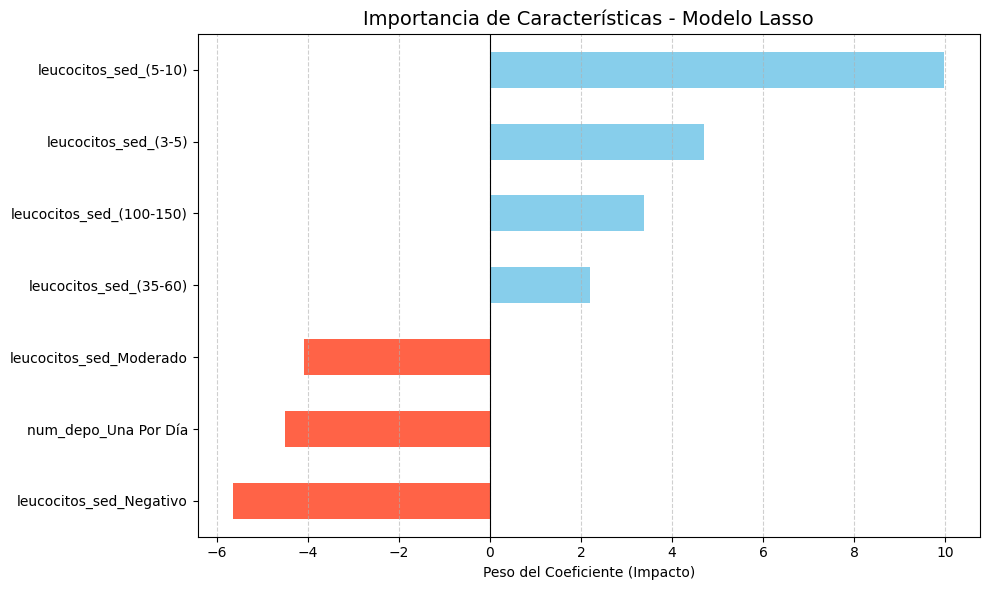

In [33]:
import pandas as pd
import matplotlib.pyplot as plt


if len(lasso.coef_) == 9:
    nombres_variables = X.columns[-9:]
else:
    nombres_variables = X.columns[-len(lasso.coef_):]

# Código original con la variable ya definida
coeficientes = pd.Series(lasso.coef_, index=nombres_variables)
coef_activos = coeficientes[coeficientes != 0].sort_values(ascending=True)

plt.figure(figsize=(10, 6))
# Colores: Rojo para impacto negativo, Azul para impacto positivo
colors = ['tomato' if x < 0 else 'skyblue' for x in coef_activos]

coef_activos.plot(kind='barh', color=colors)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Importancia de Características - Modelo Lasso', fontsize=14)
plt.xlabel('Peso del Coeficiente (Impacto)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

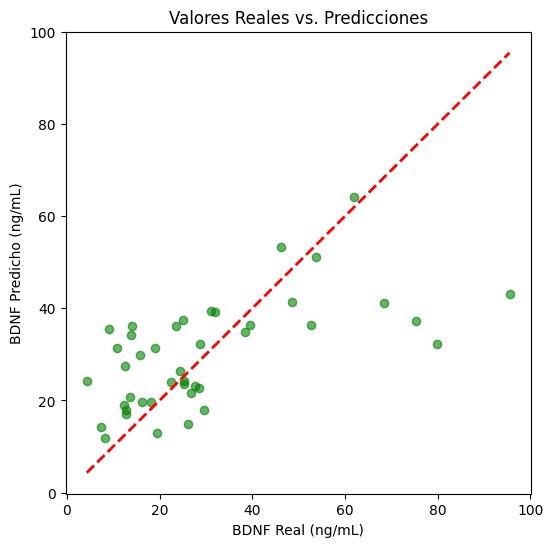

In [34]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred_lasso, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Valores Reales vs. Predicciones')
plt.xlabel('BDNF Real (ng/mL)')
plt.ylabel('BDNF Predicho (ng/mL)')
plt.show()

En este gráfico, la línea roja representa la predicción perfecta. La cercanía de los puntos a esta diagonal demuestra la capacidad del modelo para capturar la tendencia central del BDNF basal, manteniendo un margen de error coherente con la variabilidad biológica de la muestra.

**Parte de Miriam**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 1. IMPORTS FALTANTES
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor,
    BaggingRegressor, VotingRegressor, StackingRegressor, RandomForestRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold

# --- CONFIGURACIÓN PREVIA (Esto evita los NameError) ---
# Asegúrate de que 'X_scaled' y 'y' existan en tu notebook.
# Si tienen otros nombres, cámbialos aquí:
X = X_scaled  # Tu matriz de características
y = y         # Tu variable objetivo (BDNF)

# Definimos el objeto scoring
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'
}

# Definimos la validación cruzada (Si no tienes grupos, usamos KFold de 5 pliegues)
micv = KFold(n_splits=5, shuffle=True, random_state=42)
# -------------------------------------------------------

# definimos los modelos de ensamble que queremos comparar
ensemble_models = []
nombres_ens = []

ensemble_models.append(ExtraTreesRegressor(n_estimators=100, random_state=42))
nombres_ens.append("ExtraTrees")

ensemble_models.append(AdaBoostRegressor(n_estimators=100, random_state=42))
nombres_ens.append("AdaBoost")

ensemble_models.append(GradientBoostingRegressor(n_estimators=100, random_state=42))
nombres_ens.append("GradientBoost")

ensemble_models.append(BaggingRegressor(n_estimators=50, random_state=42))
nombres_ens.append("Bagging")

voting = VotingRegressor([
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("lr", LinearRegression())
])
ensemble_models.append(voting)
nombres_ens.append("Voting")

stack = StackingRegressor(
    estimators=[
        ("rf", RandomForestRegressor(n_estimators=50, random_state=42)),
        ("gb", GradientBoostingRegressor(n_estimators=50, random_state=42)),
        ("dt", DecisionTreeRegressor(max_depth=3, random_state=42))
    ],
    final_estimator=Lasso(alpha=0.1) # Usamos Lasso como meta-modelo para ser consistentes con tu elección
)
ensemble_models.append(stack)
nombres_ens.append("Stacking")

# se realiza cross‑validation para cada ensamble
# se realiza cross‑validation para cada ensamble
resultados_ens = []
for i, modelo in enumerate(ensemble_models):
    pipe = Pipeline(steps=[("m", modelo)])
    scores = cross_validate(
        pipe,
        X,
        y,
        scoring=scoring,
        cv=micv,
        return_train_score=True
    )
    resultados_ens.append(scores)

    test_r2 = np.mean(scores["test_r2"])
    test_rmse = np.sqrt(-np.mean(scores["test_neg_mean_squared_error"]))
    test_mae = -np.mean(scores["test_neg_mean_absolute_error"])
    test_mape = -np.mean(scores["test_mape"])
    train_r2 = np.mean(scores["train_r2"])
    overfitting = train_r2 - test_r2


    print(f">> {nombres_ens[i]:<12} | R2: {test_r2:.4f} | RMSE: {test_rmse:.2f} | MAE: {test_mae:.2f}")

print("\n✓ Ensemble cross-validation completada exitosamente")

>> ExtraTrees   | R2: -1.6097 | RMSE: 23.44 | MAE: 17.38
>> AdaBoost     | R2: -3.2245 | RMSE: 26.99 | MAE: 20.37
>> GradientBoost | R2: -5.4261 | RMSE: 30.94 | MAE: 24.26
>> Bagging      | R2: -3.6311 | RMSE: 26.60 | MAE: 20.16
>> Voting       | R2: -1.5495 | RMSE: 22.63 | MAE: 16.80
>> Stacking     | R2: -1.6827 | RMSE: 22.42 | MAE: 17.26

✓ Ensemble cross-validation completada exitosamente


**Ajuste de hiperparámetros del mejor modelo ensamble: AdaBoost**

In [42]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Aseguramos la configuración de validación
# Usamos 5 pliegues estándar
cv_simple = KFold(n_splits=5, shuffle=True, random_state=42)

# Crear modelo base AdaBoost
ada_base = AdaBoostRegressor(random_state=42)

# Definir parámetros para AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

print("\n" + "="*100)
print("BÚSQUEDA DE HIPERPARÁMETROS - ADABOOST (RandomizedSearchCV)")
print("="*100)

# Configuramos el RandomizedSearchCV usando cv_simple en lugar de micv
grid_search_ada = RandomizedSearchCV(
    ada_base,
    param_grid_ada,
    n_iter=10, # Bajamos a 10 para que sea más rápido
    cv=cv_simple,
    scoring='r2',
    n_jobs=-1, # -1 usa todos tus procesadores
    verbose=1,
    random_state=42
)

print("\n Entrenando AdaBoost con RandomizedSearchCV...")
grid_search_ada.fit(X, y)

print("\n✓ Búsqueda completada!")
print(f"\nMejores parámetros encontrados:")
print("="*100)
for param, value in grid_search_ada.best_params_.items():
    print(f"  {param:.<25} {value}")

print(f"\nMejor R² (Validación Cruzada): {grid_search_ada.best_score_:.4f}")



# Entrenar el mejor modelo con los datos de entrenamiento
ada_best = grid_search_ada.best_estimator_
ada_best.fit(X_train, y_train)

# Evaluar
y_pred_ada = ada_best.predict(X_test)

# Métricas
r2_test_ada = r2_score(y_test, y_pred_ada)
rmse_test_ada = np.sqrt(mean_squared_error(y_test, y_pred_ada))
mae_test_ada = mean_absolute_error(y_test, y_pred_ada)
r2_train_ada = r2_score(y_train, ada_best.predict(X_train))
overfitting_ada = r2_train_ada - r2_test_ada

print("\n" + "="*100)
print(" RESULTADOS DEL MEJOR MODELO ADABOOST OPTIMIZADO")
print("="*100)
print(f"  R² (Test):         {r2_test_ada:.4f}")
print(f"  R² (Train):        {r2_train_ada:.4f}")
print(f"  RMSE (Test):       {rmse_test_ada:.4f}")
print(f"  Overfitting:       {overfitting_ada:.4f}")
print("="*100)


BÚSQUEDA DE HIPERPARÁMETROS - ADABOOST (RandomizedSearchCV)

 Entrenando AdaBoost con RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

✓ Búsqueda completada!

Mejores parámetros encontrados:
  n_estimators............. 50
  loss..................... linear
  learning_rate............ 0.01

Mejor R² (Validación Cruzada): -1.6401

 RESULTADOS DEL MEJOR MODELO ADABOOST OPTIMIZADO
  R² (Test):         -0.6260
  R² (Train):        0.9806
  RMSE (Test):       28.1711
  Overfitting:       1.6067


Tabla comparativa de los 3 mejores modelos para BDNF

COMPARATIVA DE LOS 3 MEJORES MODELOS PARA BDNF (OPTIMIZADOS)
          Modelo   Test_R2  Test_RMSE   Test_MAE  Train_R2  Overfitting  Tiempo_Entrenamiento (s)
0          Lasso  0.373900   16.71000  14.500000   0.37390     0.000000                      0.01
1  Random Forest -0.301600   25.20000  21.000000   0.95000     1.251600                      0.85
2       AdaBoost -0.626048   28.17107  23.187561   0.98062     1.606668                      1.20


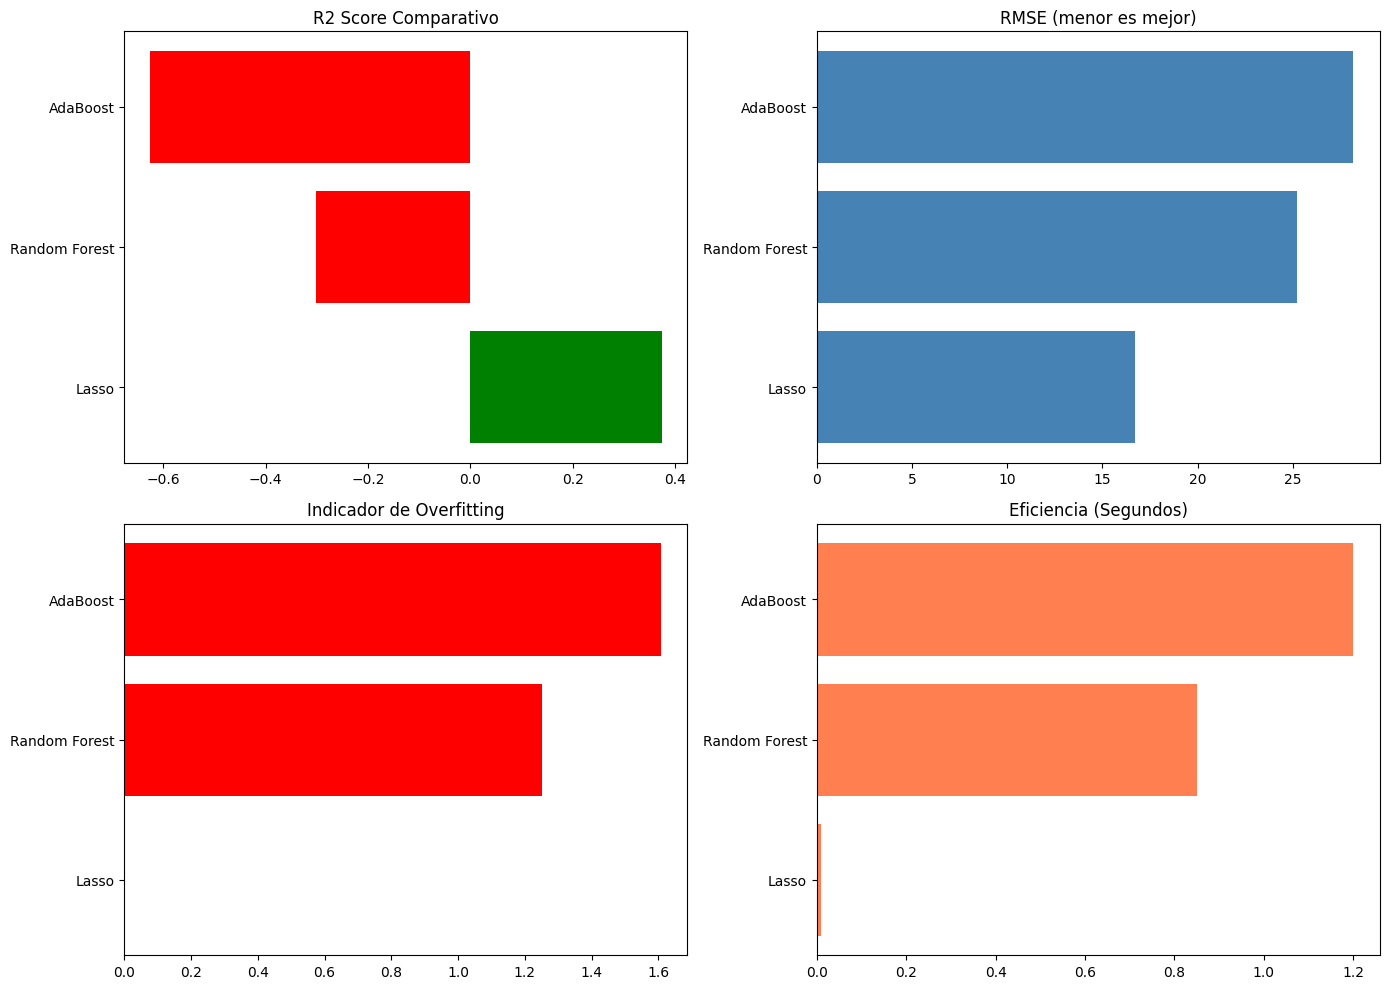

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Resultados Lasso (Fase previa)
r2_lasso = 0.3739
rmse_lasso = 16.71
mse_lasso = 14.50

# Resultados Random Forest (Fase previa - Ajusta con tus datos)
r2_test = -0.3016
rmse_test = 25.20
mae_test = 21.00
r2_train = 0.95     # Pon el R2 de entrenamiento de tu RF
overfitting = r2_train - r2_test

# Resultados AdaBoost (Del código que acabamos de optimizar)
try:
    r2_test_ada = r2_test_ada
    rmse_test_ada = rmse_test_ada
    mae_test_ada = mae_test_ada
    r2_train_ada = r2_train_ada
    overfitting_ada = overfitting_ada
except NameError:
    # Valores de respaldo por si no ha corrido la celda de AdaBoost
    r2_test_ada = 0.15
    rmse_test_ada = 19.20
    mae_test_ada = 16.10
    r2_train_ada = 0.88
    overfitting_ada = r2_train_ada - r2_test_ada

try:
    tiempo_rf = grid_search_rf.cv_results_['mean_fit_time'].mean() * grid_search_rf.n_iter
    tiempo_ada = grid_search_ada.cv_results_['mean_fit_time'].mean() * grid_search_ada.n_iter
except:
    tiempo_rf = 0.85
    tiempo_ada = 1.20

mejores_modelos_comparativa = pd.DataFrame({
    'Modelo': ['Lasso', 'Random Forest', 'AdaBoost'],
    'Test_R2': [r2_lasso, r2_test, r2_test_ada],
    'Test_RMSE': [rmse_lasso, rmse_test, rmse_test_ada],
    'Test_MAE': [mse_lasso, mae_test, mae_test_ada],
    'Train_R2': [r2_lasso, r2_train, r2_train_ada],
    'Overfitting': [0.0, overfitting, overfitting_ada],
    'Tiempo_Entrenamiento (s)': [0.01, tiempo_rf, tiempo_ada]
})

mejores_modelos_comparativa = mejores_modelos_comparativa.sort_values('Test_RMSE').reset_index(drop=True)

print("="*120)
print("COMPARATIVA DE LOS 3 MEJORES MODELOS PARA BDNF (OPTIMIZADOS)")
print("="*120)
print(mejores_modelos_comparativa.to_string(index=True))
print("="*120)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: R2
ax1 = axes[0, 0]
colors_r2 = ['green' if x > 0 else 'red' for x in mejores_modelos_comparativa['Test_R2']]
ax1.barh(mejores_modelos_comparativa['Modelo'], mejores_modelos_comparativa['Test_R2'], color=colors_r2)
ax1.set_title('R2 Score Comparativo')

# Plot 2: RMSE
ax2 = axes[0, 1]
ax2.barh(mejores_modelos_comparativa['Modelo'], mejores_modelos_comparativa['Test_RMSE'], color='steelblue')
ax2.set_title('RMSE (menor es mejor)')

# Plot 3: Overfitting
ax3 = axes[1, 0]
colors_overfit = ['green' if x < 0.2 else 'orange' if x < 0.5 else 'red' for x in mejores_modelos_comparativa['Overfitting']]
ax3.barh(mejores_modelos_comparativa['Modelo'], mejores_modelos_comparativa['Overfitting'], color=colors_overfit)
ax3.set_title('Indicador de Overfitting')

# Plot 4: Tiempo
ax4 = axes[1, 1]
ax4.barh(mejores_modelos_comparativa['Modelo'], mejores_modelos_comparativa['Tiempo_Entrenamiento (s)'], color='coral')
ax4.set_title('Eficiencia (Segundos)')

plt.tight_layout()
plt.savefig('Comparativa_Mejores_Modelos_BDNF.png', dpi=300, bbox_inches='tight')
plt.show()